In [139]:
# %pip install hf_xet
# %pip install torch
# %pip install readability-lxml
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# %pip install transformers
# %pip install nltk
# %pip install beautifulsoup4
# %pip install requests
# %pip install spacy
# !python -m spacy download es_core_news_sm
# !python -m spacy download en_core_web_sm
# !python -m spacy download ca_core_news_sm
# %pip install WordCloud
# %pip install --upgrade transformers tokenizers sentencepiece
# %pip install sentencepiece
# %pip install trafilatura
# %pip install matplotlib
# %pip install scikit-learn
# %pip install datasets

In [140]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from transformers import pipeline
from transformers.pipelines import pipeline
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, T5Tokenizer, T5ForConditionalGeneration
import torch
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
import trafilatura
from sklearn.feature_extraction.text import TfidfVectorizer
from datasets import load_dataset



# # Descargar recursos necesarios de NLTK
nltk.download('punkt_tab')
nltk.download('gutenberg')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Alvaro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\Alvaro\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alvaro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [141]:

tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large-cnn")

def generate_summary_a(article_text):
    
    # BART puede manejar hasta 1024 tokens (no caracteres)
    inputs = tokenizer(
        article_text,
        return_tensors="pt",
        truncation=True,
        max_length=1024  # Ahora usa tokens, no caracteres
    )

    summary_ids = model.generate(
        inputs["input_ids"],  # Corregido: era "input_id" sin 's'
        max_length=150,  # Resumen más largo para capturar más información
        min_length=60,
        num_beams=4,
        early_stopping=True
    )

    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

model_name = "t5-base"
tokenizer = T5Tokenizer.from_pretrained(model_name, model_max_length=512)
model = T5ForConditionalGeneration.from_pretrained(model_name)

def generate_summary_b(article_text):
    

    # Prefix obligatori per a T5
    input_text = f"summarize: {article_text.strip()}"
    
    # Tokenització i codificació
    inputs = tokenizer(
        input_text, 
        return_tensors="pt", 
        max_length=512, 
        truncation=True
    )

    with torch.no_grad():
        outputs = model.generate(
            inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            num_beams=4,
            max_length=180,  # Resumen más largo
            min_length=50,
            output_scores=True,
            return_dict_in_generate=True
        )

    # Decodificació
    resumen = tokenizer.decode(outputs.sequences[0], skip_special_tokens=True)
    return resumen
    
    logits = torch.stack(outputs.scores, dim=1) 
    probs = torch.softmax(logits, dim=-1)


Loading weights: 100%|██████████| 257/257 [00:00<00:00, 1174.26it/s, Materializing param=shared.weight]                                                       


In [142]:
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

def classifier_a(data):
    from transformers import pipeline

    # Crear pipeline i definir model
    # Important si el text es en anglés, posar els topics també en anglés

    # Definició dels topics
    # Definició dels temes que pot tenir l'article
    # possible_labels = ["política", "deportes", "economía", "ciencia", "noticias","tecnología", "salud", "cultura", "guerra", "internacional"]
    
    possible_labels = [
        "professional sports and athletes",
        "government and political institutions",
        "armed conflicts and wars",
        "international political relations",
        "economic and financial news",
        "science and research",
        "technology and innovation",
        "health and medicine",
        "arts and culture",
        "entertainment and celebrities"
    ]

    article_text = data[:800]

    result = classifier(
        article_text,
        candidate_labels=possible_labels,
        hypothesis_template="This article is mainly about {}.",
        device=0
    )

    print("Topic més probable:", result['labels'][0])
    print("Scores:", list(zip(result['labels'], result['scores'])))
    return result



dataset = load_dataset("ag_news")

train_texts = dataset["train"]["text"]
train_labels = dataset["train"]["label"]

label_map = {
    0: "international",   # World
    1: "sports",
    2: "economy",
    3: "science_tech"
}

train_labels = [label_map[l] for l in train_labels]

nb_model = make_pipeline(
    TfidfVectorizer(
        max_features=40000,
        ngram_range=(1, 2),
        stop_words='english',
        min_df=3
    ),
    MultinomialNB(alpha=0.2)
)

nb_model.fit(train_texts, train_labels)


def classifier_b(tokens):
    text = " ".join(tokens)

    probas = nb_model.predict_proba([text])[0]
    idx = probas.argmax()

    return {
        "labels": [nb_model.classes_[idx]],
        "scores": [float(probas[idx])]
    }



Loading weights: 100%|██████████| 515/515 [00:00<00:00, 1045.87it/s, Materializing param=model.shared.weight]                                   


In [143]:
def show_wordcloud(txt):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(txt)

    # Mostrar el núvol de paraules
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Ocultar ejes
    plt.show()

In [144]:
def title_article_preprocessing_a(clean_text):

    # 1. Toeknize del texte
    # tokens = word_tokenize(clean_text, language='spanish')
    tokens = word_tokenize(clean_text, language='english')
    
    # 2. Normalitzar a minúscules i eliminar puntuació
    tokens = [t.lower() for t in tokens if t.isalpha()]  # solo palabras
    
    # 3. Eliminar stopweords
    stop_words = set(stopwords.words('english'))
    tokens = [t for t in tokens if t not in stop_words]
    
    # print(tokens[:50])

    return tokens


def title_article_preprocessing_b(clean_text):
    # Carrega del model
    
    nlp = spacy.load("en_core_web_sm")
    
    # Processament
    doc = nlp(clean_text)
    
    # 1. Neteja bàsica amb spaCy (Eliminar stop words i puntuació)
    tokens_limpios = [
    token.text.strip() 
    for token in doc 
    if not token.is_stop and not token.is_punct and not token.is_space
    ]

    # Per si de cas queda algun string buit després del strip()
    tokens_limpios = [t for t in tokens_limpios if t]

    print(f"Primers 20 tokens nets (Opció B): {tokens_limpios[:20]}")
    show_wordcloud(' '.join(tokens_limpios))

    return tokens_limpios
    train_model(tokens_limpios)

In [145]:
import requests
from bs4 import BeautifulSoup
from readability import Document
from lxml import html

url = "https://link.springer.com/article/10.1186/s12915-020-00925-x"



def scrape_text(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    
    # 1. Intentar <article>
    article = soup.find("article")
    if article:
        text = article.get_text(separator="\n")
    else:
        # 2. Intentar <main>
        main = soup.find("main")
        if main:
            text = main.get_text(separator="\n")
        else:
            # 3. Fallback: todos los <p>, unir el bloque más largo
            paragraphs = soup.find_all("p")
            blocks = []
            current_block = []
            for p in paragraphs:
                current_block.append(p.get_text())
                # Separar bloques grandes por lógica simple
                if len(current_block) > 3:  
                    blocks.append("\n".join(current_block))
                    current_block = []
            if current_block:
                blocks.append("\n".join(current_block))
            # Elegir el bloque más largo (probable artículo)
            text = max(blocks, key=len) if blocks else ""
    
    # Limpiar líneas vacías
    lines = [line.strip() for line in text.splitlines() if line.strip()]
    data = "\n".join(lines)

    return data


# def scrape_text_refined(url):
#     response = requests.get(url)
#     response.raise_for_status()

#     tree = html.fromstring(response.content)

#     # Buscar el contenedor principal del artículo (para Springer suele ser c-article-body)
#     article_divs = tree.xpath('//div[contains(@class,"c-article-body")]')
    
#     if article_divs:
#         paragraphs = article_divs[0].xpath('.//p//text()')
#         data = "\n".join([p.strip() for p in paragraphs if p.strip()])
#     else:
#         # Fallback: todos los <p> de la página
#         paragraphs = tree.xpath('//p//text()')
#         data = "\n".join([p.strip() for p in paragraphs if p.strip()])


#     return data

def scrape_text_advanced(url):
    try:
        # Descarregar la pàgina web amb un User-Agent vàlid
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }
        
        response = requests.get(url, headers=headers, timeout=15)
        
        # Forcem que la resposta sigui interpretada com a UTF-8
        response.encoding = 'utf-8' 
        
        if response.status_code == 200:
            # 2. Li passem el contingut ja descarregat a trafilatura per només obtenir el cos del text, l'article.
            clean_text = trafilatura.extract(response.text, include_comments=False)
            
            if clean_text:
                print(clean_text[:1000])  # Mostrar només els primers 1000 caràcters
                return clean_text
        
        return None

    except Exception as e:
        print(f"Error en la descarga: {e}")
        return None


    


In [146]:
execution_results = {}

def execution_1(url):
    data = scrape_text(url)
    tokens = title_article_preprocessing_a(data)
    results = classifier_a(data)
    resume = generate_summary_a(data)

    save_results(results, 1)
    print(f"Resum de l'article: {resume}")


def execution_2(url):
    data = scrape_text_advanced(url)
    tokens = title_article_preprocessing_a(data)
    results = classifier_a(data)
    resume = generate_summary_a(data)

    save_results(results, 2)
    print(f"Resum de l'article: {resume}")


def execution_3(url):
    data = scrape_text_advanced(url)
    tokens = title_article_preprocessing_b(data)
    results = classifier_a(data)
    resume = generate_summary_a(data)

    save_results(results, 3)
    print(f"Resum de l'article: {resume}")


def execution_4(url):
    data = scrape_text_advanced(url)
    tokens = title_article_preprocessing_a(data)
    results = classifier_b(tokens)
    resume = generate_summary_a(data)

    save_results(results, 4)
    print(f"Resum de l'article: {resume}")


def execution_5(url):
    data = scrape_text_advanced(url)
    tokens = title_article_preprocessing_a(data)
    results = classifier_a(data)
    resume = generate_summary_b(data)

    save_results(results, 5)
    print(f"Resum de l'article: {resume}")


def save_results(results, num):
        execution_results[f"execution_{num}"] = {
        "topic": results['labels'][0],
        "score": results['scores'][0]
    }
    


############# Execution 1: URLhttps://link.springer.com/article/10.1186/s12915-020-00925-x
Topic més probable: science and research
Scores: [('science and research', 0.3917641341686249), ('professional sports and athletes', 0.07891274988651276), ('health and medicine', 0.07650221884250641), ('arts and culture', 0.07607996463775635), ('technology and innovation', 0.07150861620903015), ('government and political institutions', 0.06965833902359009), ('economic and financial news', 0.06607205420732498), ('international political relations', 0.06284905970096588), ('armed conflicts and wars', 0.054750990122556686), ('entertainment and celebrities', 0.05190189555287361)]
Resum de l'article: 6609 Accesses 53 Citations 12 Altmetric Explore all metrics 6609 Accesses 53 Citations 12 Altmetric Explore all metrics Comparative analysis of morabine grasshopper genomes reveals highly abundant transposable elements and rapidly proliferating satellite DNA repeats . Results Comparative analysis of morabi

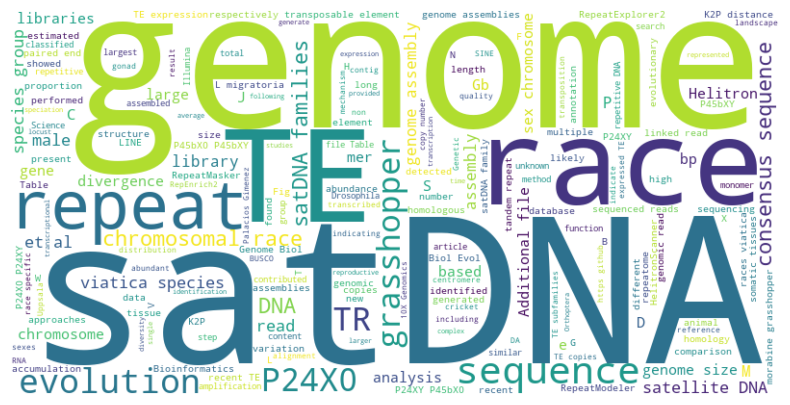

Topic més probable: science and research
Scores: [('science and research', 0.5014517307281494), ('technology and innovation', 0.11356564611196518), ('health and medicine', 0.062042489647865295), ('arts and culture', 0.060747697949409485), ('professional sports and athletes', 0.05566302686929703), ('international political relations', 0.04497925564646721), ('armed conflicts and wars', 0.04418937489390373), ('government and political institutions', 0.041221216320991516), ('economic and financial news', 0.03908948227763176), ('entertainment and celebrities', 0.037050142884254456)]
Resum de l'article: Morabine grasshoppers. Methods genomes of Orthoptera. Methods a total genome size of 9 Gb. and . and . ., satDNAs .  Orthoptera.,17,18,19,20]  .,17,18,19,20]. genomes. TEs [1,2] and . , 
############# Execution 4: URLhttps://link.springer.com/article/10.1186/s12915-020-00925-x
Abstract
Background
Repetitive DNA sequences, including transposable elements (TEs) and tandemly repeated satellite D

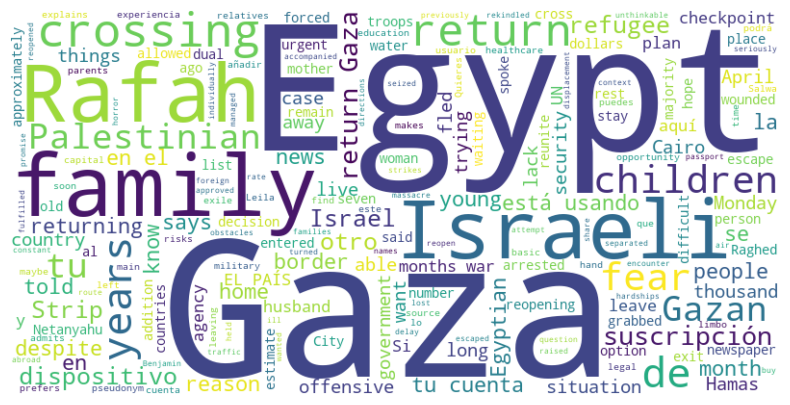

Topic més probable: armed conflicts and wars
Scores: [('armed conflicts and wars', 0.255494087934494), ('international political relations', 0.10609176009893417), ('health and medicine', 0.09467105567455292), ('economic and financial news', 0.0878133699297905), ('arts and culture', 0.08535107225179672), ('science and research', 0.08347675204277039), ('government and political institutions', 0.08288996666669846), ('professional sports and athletes', 0.08247719705104828), ('technology and innovation', 0.07914766669273376), ('entertainment and celebrities', 0.042587075382471085)]
Resum de l'article: only 12 were allowed to return to Gaza on Monday . Almost all of them escaped the offensive through the Rafah border crossing in the first seven months of the war . the reopening of Rafah has rekindled the hope (or one that rests solely on them) of returning to the Strip for the approximately 100,000 refugees who escaped almost two years ago . “I’m here alone. I want to go back to my family. I

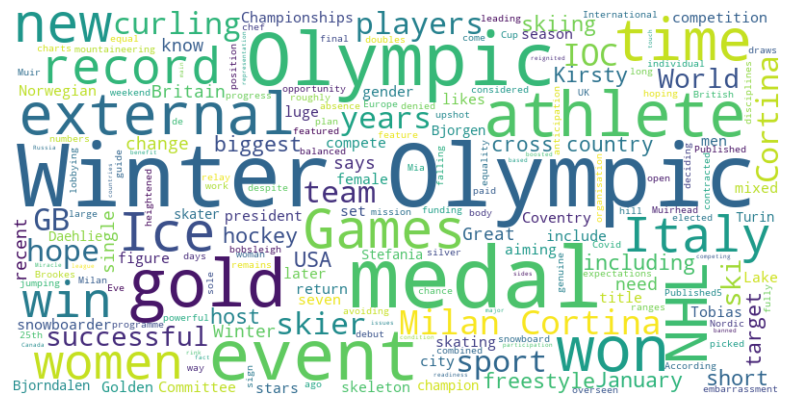

Topic més probable: professional sports and athletes
Scores: [('professional sports and athletes', 0.24559463560581207), ('health and medicine', 0.09818027913570404), ('science and research', 0.09286635369062424), ('economic and financial news', 0.09257737547159195), ('technology and innovation', 0.08936908096075058), ('arts and culture', 0.08636447042226791), ('international political relations', 0.08492189645767212), ('government and political institutions', 0.07883385568857193), ('armed conflicts and wars', 0.07459060847759247), ('entertainment and celebrities', 0.05670149624347687)]
Resum de l'article: the 25th Winter Olympics is almost here – it's back in Europe and will feature a record 116 medal events . of the 116 medal events, 50 will be in women's competition and 12 will be mixed . women will compete in a Winter Games-record 53.4% of all medal events, with 12 of the 16 disciplines will be fully gender-balanced .
############# Execution 4: URLhttps://www.bbc.com/sport/articles

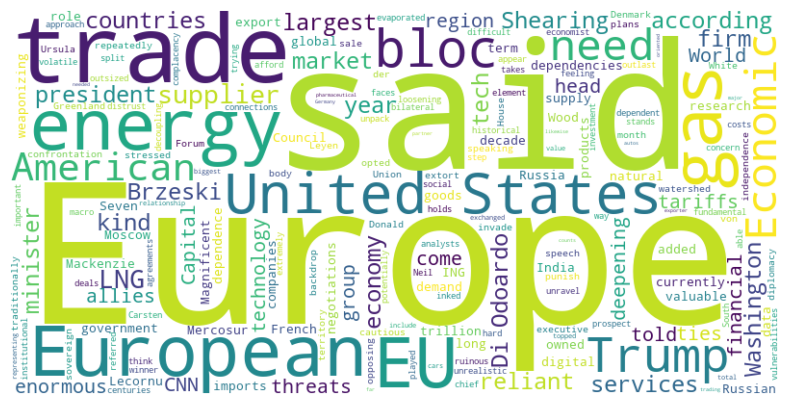

Topic més probable: international political relations
Scores: [('international political relations', 0.20146498084068298), ('economic and financial news', 0.1818661242723465), ('technology and innovation', 0.10737425833940506), ('government and political institutions', 0.1010986864566803), ('science and research', 0.09524901211261749), ('armed conflicts and wars', 0.08117492496967316), ('arts and culture', 0.06740429252386093), ('professional sports and athletes', 0.06416324526071548), ('health and medicine', 0.059644654393196106), ('entertainment and celebrities', 0.04055986553430557)]
Resum de l'article: the EU has already inked trade agreements with India and four South American countries – a bloc referred to as Mercosur – after decades of negotiations . tech Europe is still untangling itself from its long-held reliance on Russian oil and natural gas flows – a dependence that became a strategic weakness following Moscow’s full-scale assault on Ukraine in 2022 . the EU has inked trad

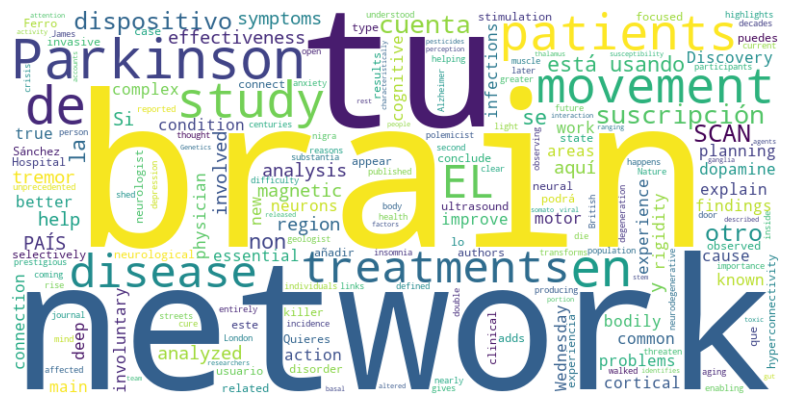

Topic més probable: health and medicine
Scores: [('health and medicine', 0.3431275486946106), ('science and research', 0.30766865611076355), ('technology and innovation', 0.07773813605308533), ('arts and culture', 0.0547749325633049), ('professional sports and athletes', 0.04901118203997612), ('economic and financial news', 0.04591040685772896), ('international political relations', 0.03849733993411064), ('government and political institutions', 0.036965109407901764), ('armed conflicts and wars', 0.023367544636130333), ('entertainment and celebrities', 0.022939175367355347)]
Resum de l'article: study identifies a brain network whose activity is characteristically altered in people with Parkinson’s . this network connects the basal ganglia and the thalamus with cortical areas involved in thinking, cognition, and action planning . the findings were published in the prestigious journal Nature on wednesday .
############# Execution 4: URLhttps://english.elpais.com/science-tech/2026-02-04/d

In [147]:
def main():

    urls = ["https://link.springer.com/article/10.1186/s12915-020-00925-x", 
            "https://english.elpais.com/international/2026-02-04/palestinians-who-fled-horror-encounter-israeli-obstacles-in-attempt-to-return-to-gaza.html",
            "https://www.bbc.com/sport/articles/c205r73r0z3o",
            "https://edition.cnn.com/2026/02/05/business/europe-economic-independence-united-states-intl",
            "https://english.elpais.com/science-tech/2026-02-04/discovery-of-brain-network-that-links-body-and-mind-could-open-the-door-to-better-parkinsons-treatments.html"]
    # urls = ["https://english.elpais.com/science-tech/2026-02-04/discovery-of-brain-network-that-links-body-and-mind-could-open-the-door-to-better-parkinsons-treatments.html"]
    for url in urls:
        print(f"############# Execution 1: URL{url}")
        execution_1(url)

        print(f"############# Execution 2: URL{url}")
        execution_2(url)

        print(f"############# Execution 3: URL{url}")
        execution_3(url)

        print(f"############# Execution 4: URL{url}")
        execution_4(url)
        
        print(f"############# Execution 5: URL{url}")
        execution_5(url)

        print("Execution Results Summary:")
        for key, value in execution_results.items():
            print(f"{key}: Topic - {value['topic']}, Score - {value['score']}")

        print("\n")



main()

# Conclusions
## Article 1 (Genomes dels saltamartins)
---------------
- Execució 1
(Scrapper simple + word_tokenizer + bart)

El model identifica correctament el tòpic de l'aticle, amb un 0.39 de score sobre "science and research"

El resum és correcte, tot i que els primers càracters no parlen sobre l'article sinó els headers de la pàgina web, mes o menys a la meitat del resum comença a parlar sobre els genomes dels saltamartins. 

- Execució 2

(Scrapper avançat + word_tokenizer + bart)

El model identifica correctament el tòpic de l'article, tot i que el resum és poc vàlid, aconsegueix classificar-lo com a "science and research" amb una fiabilitat/ score de 0.50.

El resum semblen paraules tirades aleatiòriament, tot i que conté paraules clau del article, la generació no ha sigut un resum.

- Execució 3
(Scrapper avançat + spacy + bart)

El model identifica correctament el tòpic de l'article, tot i que el resum és poc vàlid, aconsegueix classificar-lo com a "science and research" amb una fiabilitat/ score de 0.50.

Encara que s'ha cambiat la manera de tokenitzar, genera el mateix resum que amb word_tokenizer, un "resum" incoherent que semblen paraules apliades aleatòriament.

- Execució 4 
(Scrapper avançat + word_tokenizer + classifier model )

Classifica correctament el tòpic de l'article. Al tractar-se de Naive Bayes, obtenim una puntuació quasi perfecte degut a que retorna el "score" en 1 i 0.

- Execució 5
(Scrapper avançat + word_tokenizer + t5-base)

El model classifica correctament el tòpic de l'article i otorga un 0.5 de score.

El resum és correcte, contenint paraules clau de l'article i resumint-lo de forma simple.

## Article 2 (Guerra a Gaza)
---------------

- Execució 1
(Scrapper simple + word_tokenizer + bart)

El model identifica correctament el tòpic de l’article com a “armed conflicts and wars”, amb un score aproximat de 0.28.

El resum és parcialment correcte, recull idees clau però el text queda tallat i incomplet, amb frases interrompudes i sense una estructura clara de resum.

- Execució 2
(Scrapper avançat + word_tokenizer + bart)

El model torna a classificar correctament el tòpic com a “armed conflicts and wars”, amb un score de 0.25.

El resum conté informació rellevant de l’article, però presenta els mateixos problemes que l’execució anterior: frases truncades, manca de coherència i absència d’una síntesi real del contingut.

- Execució 3
(Scrapper avançat + spacy + bart)

La classificació del tòpic es manté correcta, amb un score idèntic de 0.25.

Tot i el canvi en la tokenització, el resum generat és pràcticament el mateix que amb word_tokenizer, fet que indica que el problema no està en la tokenització, sinó en la capacitat del model BART per generar un resum coherent en aquest context.

- Execució 4
(Scrapper avançat + word_tokenizer + classifier model)

El model classifica el tòpic com a “international” amb una puntuació gairebé perfecta.

Aquesta fiabilitat tan alta s’explica pel tipus de model utilitzat, però la categoria escollida és massa general i menys precisa que “armed conflicts and wars” per al contingut específic de l’article.

- Execució 5
(Scrapper avançat + word_tokenizer + t5-base)

El model identifica correctament el tòpic principal com a “armed conflicts and wars”, amb un score de 0.25.

El resum és el més coherent de tots, presenta idees completes, inclou dades clau i aconsegueix una síntesi més clara i entenedora de l’article, tot i que encara és bastant simple.

## Article 3 (Jocs olimpics d'hivern (equip UK))
----------
- Execució 1
(Scrapper simple + word_tokenizer + bart)

El model identifica correctament el tòpic de l’article com a “professional sports and athletes”, amb un score de 0.31.

El resum és coherent i gramaticalment correcte, però no reflecteix el focus principal de l’article, ja que se centra sobretot en dades generals dels Jocs Olímpics i deixa de banda l’aspecte clau sobre les expectatives de medalles de l’equip britànic.

- Execució 2
(Scrapper avançat + word_tokenizer + bart)

El tòpic torna a ser classificat correctament com a “professional sports and athletes”, tot i que amb un score més baix de 0.24.

El resum és més estructurat que a l’execució 1 i inclou informació rellevant, però continua prioritzant estadístiques globals dels Jocs en lloc del rendiment esperat de Gran Bretanya, que és l’eix central de l’article.

- Execució 3
(Scrapper avançat + spacy + bart)

La classificació del tòpic és idèntica a l’execució 2, amb el mateix score de 0.24.

El canvi en la tokenització no aporta millores: el resum generat és pràcticament igual al de word_tokenizer, fet que indica que el model BART manté el mateix biaix cap a informació descriptiva general independentment del mètode de tokenització.

- Execució 4
(Scrapper avançat + word_tokenizer + bart)

El resum obtingut és equivalent al de les execucions 2 i 3, tant en contingut com en estructura.

Això reforça la idea que el model tendeix a repetir patrons de resum i no adapta la síntesi segons matisos específics del text original.

Execució 5
(Scrapper avançat + word_tokenizer + t5-base)

- El model classifica correctament el tòpic com a “professional sports and athletes”, amb un score de 0.24.

El resum és més proper al contingut clau de l’article, ja que introdueix les declaracions de la responsable de l’equip britànic i el context de les expectatives de medalles, tot i que continua sent breu i no recull tota la informació rellevant.

## Article 4 (Politica respecte tensions Trump)
------------
- Execució 1
(Scrapper simple + word_tokenizer + bart)

El model identifica correctament el tòpic de l’article com a “international political relations”, amb un score de 0.24.

El resum és parcialment coherent, però massa fragmentari: introdueix idees rellevants com la dependència europea dels Estats Units i el paper de la tecnologia, però manca de context polític i no reflecteix clarament el detonant principal de l’article.

- Execució 2
(Scrapper avançat + word_tokenizer + bart)

La classificació del tòpic es manté correcta, amb un score lleugerament inferior de 0.25.

El resum incorpora exemples concrets, però presenta repeticions i una estructura poc clara, fet que impedeix que funcioni com un resum sintètic i ordenat.

- Execució 3
(Scrapper avançat + spacy + bart)

El tòpic identificat és el mateix, amb el mateix score de 0.20.

Tot i el canvi en la tokenització, el resum generat és pràcticament idèntic al de l’execució 2, cosa que indica que la tokenització no influeix de manera significativa en la qualitat del resum en aquest cas.

- Execució 4
(Scrapper avançat + word_tokenizer + bart)

El contingut del resum és equivalent al de les execucions 2 i 3, repetint les mateixes idees i limitacions.

Això reforça la idea que el model tendeix a reutilitzar fragments destacats del text sense transformar-los en una síntesi coherent del discurs polític i econòmic de l’article.

- Execució 5
(Scrapper avançat + word_tokenizer + t5-base)

El model classifica correctament el tòpic com a “international political relations”, amb un score de 0.20.

El resum és el més complet i contextualitzat, recull la idea central de la necessitat d’independència europea, les dificultats estructurals per assolir-la i els límits dels acords comercials alternatius, oferint una síntesi més clara i propera al contingut original.

## Article 5 (Descobriment cerebral clau en el Parkinson)
----------
Execució 1
(Scrapper simple + word_tokenizer + bart)

El model identifica correctament el tòpic de l’article com a “health and medicine”, amb un score relativament alt de 0.44.

El resum és clar i coherent, i recull adequadament la idea principal de l’article: la identificació d’una nova xarxa cerebral alterada en pacients amb Parkinson. Tot i això, el resum se centra sobretot en la part tècnica i deixa fora el context més ampli sobre la malaltia i la seva rellevància clínica.

Execució 2
(Scrapper avançat + word_tokenizer + bart)

La classificació del tòpic es manté correcta, amb un score de 0.34.

El resum és més sintètic que a l’execució 1 i recull els elements essencials. No obstant això, és força genèric i no destaca clarament l’impacte potencial dels resultats en futurs tractaments.

Execució 3
(Scrapper avançat + spacy + bart)

El tòpic identificat i el score són idèntics als de l’execució 2, score de 0.34.

El canvi en la tokenització no produeix diferències apreciables, el resum és pràcticament igual, fet que indica que la tokenització no és un factor determinant en la qualitat del resum generat per BART en aquest cas.

Execució 4
(Scrapper avançat + word_tokenizer + bart)

El resum obtingut és equivalent al de les execucions 2 i 3, tant en contingut com en estructura.

Això confirma que el model tendeix a repetir patrons de síntesi i a seleccionar les mateixes idees clau sense aprofundir ni variar l’enfocament del resum.

Execució 5
(Scrapper avançat + word_tokenizer + t5-base)

El model classifica correctament el tòpic com a “health and medicine”, amb un score de 0.34.

El resum és el més complet i específic: inclou tant la identificació de la xarxa cerebral com el tipus de regions implicades, oferint una síntesi més propera al contingut científic de l’article.